In [ ]:
# ! pip install pymongo


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from mongo import MongoDBManager
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# Retrieving data

In [2]:
load_dotenv()
uri = os.getenv('MONGODB_URI')
database_name = os.getenv('DATABASE_NAME')
mongo_manager = MongoDBManager(uri, database_name)

In [3]:
documents = mongo_manager.read_all_documents_in_collection_with_GridFS()

In [4]:
def data_recurcive_length(data):
    total = 0
    try:
        for key in data.keys():
            for profession in data[key].keys():
                for language in data[key][profession].keys():
                    print(f"{key} - {profession} - {language} : {len(data[key][profession][language])}")
                    total += len(data[key][profession][language])
        print(f"Total: {total}")
    except Exception as e:
        print(e)
        print(data[key][profession])

In [5]:
data_recurcive_length(documents)

Canada - Agente ou agent communautaire, de développement, de planification, des politiques sociales, de programmation, de recherche - fr : 13
Canada - Accompagnatrice spirituelle ou accompagnateur spirituel - fr : 101
Canada - Accompagnatrice spirituelle ou accompagnateur spirituel - en : 23
Canada - Accompagnatrice, accompagnateur, musicienne ou musicien dans de petits ensembles - fr : 179
Canada - Accompagnatrice, accompagnateur, musicienne ou musicien dans de petits ensembles - en : 1040
Canada - Actuaire - fr : 119
Canada - Actuaire - en : 609
Canada - Acheteuse ou acheteur - fr : 634
Canada - Acheteuse ou acheteur - en : 1212
Canada - Adjointe ou adjoint à la recherche - fr : 705
Canada - Adjointe ou adjoint à la recherche - en : 907
Canada - Administratrice ou administrateur - fr : 518
Canada - Administratrice ou administrateur - en : 1398
Canada - Administratrice ou administrateur de contrats - fr : 128
Canada - Administratrice ou administrateur de contrats - en : 1104
Canada - 

# Formating Datas

In [6]:
def data_to_sql_format(data):
    data_formated = []
    for country in documents.keys():
        for profession in documents[country].keys():
            for language in documents[country][profession].keys():
                    for data in documents[country][profession][language]:
                        data['country'] = country
                        data['profession'] = profession
                        data['language'] = language
                        data_formated.append(data)
    return data_formated                    
data_formated=data_to_sql_format(documents)
print(len(data_formated))

37147


In [9]:
#import dedupe

def clear_data(data):
    df=pd.DataFrame(data)
    df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)
    df=df.drop_duplicates()
    df.describe()
    countries = df["country"].drop_duplicates().to_list()
    professions = df["profession"].drop_duplicates().to_list()
    languages = df["language"].drop_duplicates().to_list()
    clear_data={}
    for country in countries:
        for profession in professions:
            for lang in languages:
                try:
                    if country not in clear_data:
                        clear_data[country] = {}
                    if profession not in clear_data[country]:
                        clear_data[country][profession] = {}
                    
                    filtered_df = df[(df["language"] == lang) & (df["profession"] == profession) & (df["country"] == country)]
                    clear_data[country][profession][lang] = filtered_df.to_dict('records')
                except Exception as e:
                    print(e)
                
    return clear_data

data_cleared = clear_data(data_formated)

In [10]:
data_recurcive_length(data_cleared)

Canada - Agente ou agent communautaire, de développement, de planification, des politiques sociales, de programmation, de recherche - fr : 11
Canada - Agente ou agent communautaire, de développement, de planification, des politiques sociales, de programmation, de recherche - en : 0
Canada - Accompagnatrice spirituelle ou accompagnateur spirituel - fr : 101
Canada - Accompagnatrice spirituelle ou accompagnateur spirituel - en : 20
Canada - Accompagnatrice, accompagnateur, musicienne ou musicien dans de petits ensembles - fr : 179
Canada - Accompagnatrice, accompagnateur, musicienne ou musicien dans de petits ensembles - en : 1040
Canada - Actuaire - fr : 119
Canada - Actuaire - en : 609
Canada - Acheteuse ou acheteur - fr : 634
Canada - Acheteuse ou acheteur - en : 1212
Canada - Adjointe ou adjoint à la recherche - fr : 705
Canada - Adjointe ou adjoint à la recherche - en : 907
Canada - Administratrice ou administrateur - fr : 518
Canada - Administratrice ou administrateur - en : 1398
C

# Visualizing Data

In [11]:
df = pd.DataFrame(data_formated)
df.describe()

,positionTitle,companyName,location,salaryInfoAndJobType,description,datePosted,salary,jobType,shiftAndSchedule,jobBenefits,updatedDate,country,profession,language
count,37147,37147,37147,37147,37147,36125,37147,37147,37147,37147,37147,37147,37147,37147
unique,14897,7710,6530,5413,11539,61,3233,322,584,3164,16,3,18,2
top,Office Administrator,,"Montréal, QC",Full-time,,,,[],,[],2024-09-13,Canada,"Agente commerciale ou agent commercial, politi...",en
freq,450,297,924,4084,302,4493,17627,8222,26765,17676,9015,15686,6458,27072


In [13]:
indeedJobData =df.to_json(orient='records', force_ascii=False, indent=4)
with open('indeedJobData.json', 'w') as f:
    f.write(indeedJobData)

In [12]:
df['description'] = df['description'].str.replace('\n', ' ')
df.to_csv('indeedJobData.csv', index=False, quoting=1 , sep=';')

In [14]:
df[df['shiftAndSchedule'] != ''].describe()

,positionTitle,companyName,location,salaryInfoAndJobType,description,datePosted,salary,jobType,shiftAndSchedule,jobBenefits,updatedDate,country,profession,language
count,10382,10382,10382,10382,10382,10071,10382,10382,10382,10382,10382,10382,10382,10382
unique,5546,2772,2569,2209,3377,61,1356,129,583,1603,12,2,17,2
top,Office Administrator,PHSA,"Montréal, QC",Full-time,POSTE AVEC BEAUCOUP DE DÉPLACEMENT SERVICES E...,,,,[Monday to Friday],[],2024-09-13,Canada,Administratrice ou administrateur,en
freq,220,187,278,864,44,1024,3674,1890,1333,3220,3213,6156,1725,8309


In [15]:
df[:5]

,positionTitle,companyName,location,salaryInfoAndJobType,description,datePosted,salary,jobType,shiftAndSchedule,jobBenefits,updatedDate,country,profession,language
0,"Agent ou agente de planification, de programma...",CISSSCA,"Lévis, QC","De 29,50 $ à 52,28 $ de l’heure - Temporaire, ...",Présentation de l'organisation Le Centre intég...,2024-08-30,"De 29,50 $ à 52,28 $ de l’heure","[Temporaire, Temps plein]",,"[Jours fériés payés, Programme d'Aide aux Empl...",2024-09-09,Canada,"Agente ou agent communautaire, de développemen...",fr
1,"Agent ou agente de planification, de programma...",CIUSSS de la Capitale-Nationale,"Ville de Québec, QC•Travail hybride","Permanent, Temps plein",Sommaire du rôle et des responsabilités : Sou...,2024-09-06,,"[Permanent, Temps plein]",Quart de jour\nDu Lundi au Vendredi,[],2024-09-09,Canada,"Agente ou agent communautaire, de développemen...",fr
2,Agente ou agent de recherche et de planificati...,Université Laval,"2705 ​​Laurier Boulevard, Ville de Québec, QC","Temporaire, Temps plein",Agente ou agent de recherche et de planificati...,2024-09-06,,"[Temporaire, Temps plein]",,"[Heures d’arrivée et de départ flexibles, Jour...",2024-09-09,Canada,"Agente ou agent communautaire, de développemen...",fr
3,Directeur(trice) des ventes,Mont-Joli Chrysler,"1325 Boul Jacques-Cartier, Mont-Joli, QC","Permanent, Temps plein",Notre concessionnaire Mont-Joli Chrysler est p...,2024-09-06,,"[Permanent, Temps plein]",,[],2024-09-09,Canada,"Agente ou agent communautaire, de développemen...",fr
4,"Agent ou agente de planification, de programma...",CISSSCA,"Lévis, QC","De 29,50 $ à 52,28 $ de l’heure - Permanent, T...",Présentation de l'organisation Le Centre intég...,2024-08-10,"De 29,50 $ à 52,28 $ de l’heure","[Permanent, Temps plein]",,"[Jours fériés payés, Programme d'Aide aux Empl...",2024-09-09,Canada,"Agente ou agent communautaire, de développemen...",fr


In [16]:
df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)
df = df.drop_duplicates()

df = df[((df['positionTitle'] != '') & (df['description'] != '')) | df['positionTitle'] != '']
df["jobType"] = df["jobType"].replace(' () ', '')
"""
df['jobType'] = df.apply(
    lambda x: tuple(list(x['jobType']) + list(x['salary'])) 
    if not re.search(r'\d+', str(x['salary'])) 
    else x['jobType'], 
    axis=1
)
"""
"""
df['salary'] = df['salary'].map(
    lambda x: '' 
    if not re.search(r'\d+', str(x))
    else x
)

df['salary'] = df.apply(
    lambda x: str(x['salary']+"-"+str(list(x['jobType'])[0]) )
    if not re.search(r'\d+', str(list(x['jobType'])[0])) 
    else str(x['salary']), 
    axis=1
)
professions[5:7]

df['jobType'] = df['jobType'].map(
    lambda x: '' 
    if not re.search(r'\d+', str(x))
    else x
)
"""
df.describe()

,positionTitle,companyName,location,salaryInfoAndJobType,description,datePosted,salary,jobType,shiftAndSchedule,jobBenefits,updatedDate,country,profession,language
count,36324,36324,36324,36324,36324,35329,36324,36324,36324,36324,36324,36324,36324,36324
unique,14897,7710,6530,5413,11538,61,3233,322,584,3164,16,3,18,2
top,Office Administrator,,"Montréal, QC",Full-time,,,,(),,(),2024-09-13,Canada,"Agente commerciale ou agent commercial, politi...",en
freq,445,276,873,4031,281,4454,17196,8112,26196,17280,8711,15046,6434,26479


In [17]:
for column in df.columns:
    print(column)

positionTitle
companyName
location
salaryInfoAndJobType
description
datePosted
salary
jobType
shiftAndSchedule
jobBenefits
updatedDate
country
profession
language


In [18]:
df[df['positionTitle'].str.contains('rn', case=False)==True]['positionTitle'].tolist()

['Registered Nurse/Registered Psychiatric Nurse (RN & RPN), Emergency Department / Mental Health – BC Children’s Hospital',
 'Senior Director, Learning & Development / Directeur(trice) principal(e), Formation et développement',
 'RN / RPN',
 'Registered Nurse/Registered Psychiatric Nurse (RN & RPN), Emergency Department / Mental Health – BC Children’s Hospital',
 'Registered Nurse (RN), Cancer Care - BC Cancer Prince George',
 'Home Care Aide – Ongoing Recruitment (External)',
 'Overnight Youth Worker',
 'Registered Nurse (RN)/ Registered Psychiatric Nurse (RPN), Looking Glass Residence - BC Children’s Hospital',
 'Registered Nurse (RN)/ Registered Psychiatric Nurse (RPN), Looking Glass Residence - BC Children’s Hospital',
 'Personal Support Worker Ongoing Recruitment (External)',
 'Intern and Registered Architects',
 'Registered Nurse (RN) - Endoscopy/Brachytherapy PARR, RT Program - BC Cancer - Vancouver',
 'RN / RPN',
 'Internal Medicine',
 'Internal Medicine',
 'Registered Nurse (R

In [16]:
def plot_bar_chart(df, column):
    plt.figure(figsize=(10, 6))
    for i in range(0 , df[column].nunique() , 20):
        df[column].value_counts()[i:i+20].plot(kind='bar')
        plt.show()

In [17]:
# from pandasql import sqldf

In [ ]:
plot_bar_chart(df, 'jobType')

<Axes: xlabel='jobType'>

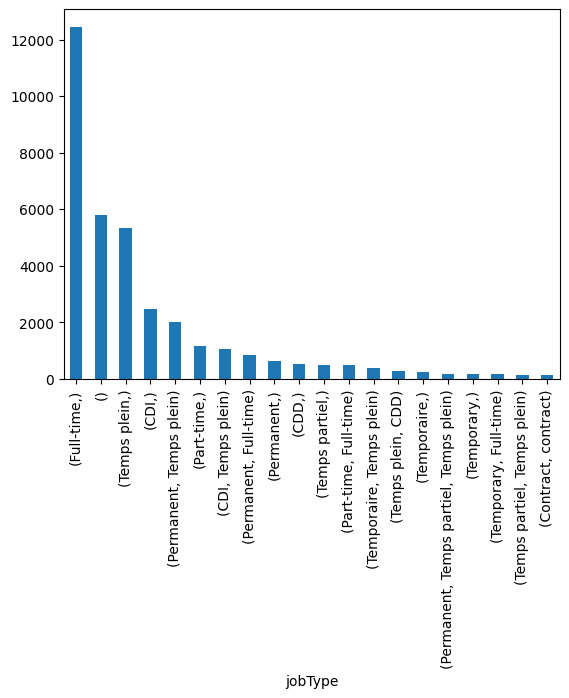

In [59]:
df_counts = df['jobType'].value_counts()[:20].plot(kind='bar')
# df_counts.plot(kind='scatter', x='positionTitle', y='location', s=df_counts['count'] * 10)
# plt.xticks(rotation=45)
# plt.show()
df_counts

<Axes: xlabel='salary'>

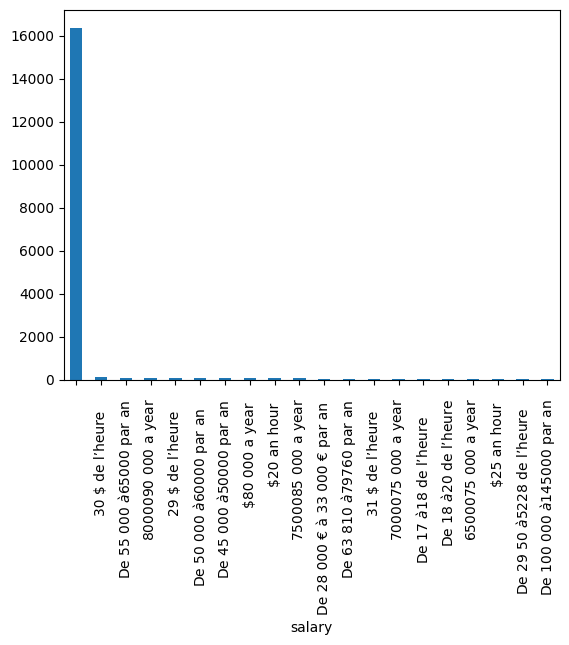

In [58]:
df['salary'] = df.apply(
    lambda x: "" 
    if not re.search(r'\d+', str(x['salary'])) 
    else x['salary'], 
    axis=1
)

# Afficher les 10 valeurs les plus fréquentes dans salary
df['salary'].value_counts()[:20].plot(kind='bar')

In [ ]:
def transform_position_title(df):
    """
    This function cleans a DataFrame containing job posting information by following these steps:
    Steps:
    1. Remove dates:
    2. Remove salary rates:
    3. Remove hourly rates:
    4. Replace codes with actual position titles where possible:
    5. Rename bad encodings:
    6. Remove job type and shift/schedule information:
    7. Remove location if possible:
    Arguments:
    - df: DataFrame containing the job postings data to be cleaned.
    Returns:
    - A cleaned DataFrame according to the steps above.
    """

    # Remove dates
    date_pattern1 = r'\d{1,2}/\d{1,2}/\d{2,4}'
    date_pattern2 = r'\d{1,2}-\d{1,2}-\d{2,4}'
    date_pattern3 = r'\d{1,2}\.\d{1,2}\.\d{2,4}'
    date_pattern4 = r'\d{1,2}\s\w+\s\d{2,4}'
    date_pattern5 = r'\w+\s\d{1,2},\s\d{4}'
    date_pattern6 = r'\d{4}-\d{2}-\d{2}'
    date_patterns = [date_pattern1, date_pattern2, date_pattern3, date_pattern4, date_pattern5, date_pattern6]
    title_df = df['positionTitle']
    title_df = title_df.map(lambda x: re.sub(pattern, '', x) for pattern in date_patterns)

    # Remove month and year
    month_year_pattern = r'\b(janvier|january|février|february|mars|march|avril|april|mai|may|juin|june|juillet|july|août|august|septembre|september|octobre|october|novembre|november|décembre|december)\s\d{4}\b'
    title_df = title_df.map(lambda x: re.sub(month_year_pattern, '', x))

    # Remove salary rates
    pattern_salary_ca = re.compile(r'(?:De\s)?([\d\s]+)\s?\$(?:\s?à\s([\d\s]+)\s?\$\s?)(?:par\s|per\s|annuel\s|yearly\s)?(year|annum|an)\s*', re.IGNORECASE)
    pattern_salary_us = re.compile(r'(?:From\s)?\$\d+(?:,\d{3})*(?:\.\d{2})?(?:–\$\d+(?:,\d{3})*(?:\.\d{2})?)?\s?(?:a|per)\s(hour|day|week|month|year)\s*', re.IGNORECASE)
    pattern_salary_fr = re.compile(r'(?:De\s)?([\d\s]+)\s?€\s?à\s([\d\s]+)\s?€\s?(?:par\s|per\s|annuel\s|yearly\s|annum\s)?(an|year)\s*', re.IGNORECASE)
    salary_patterns = [pattern_salary_ca, pattern_salary_us, pattern_salary_fr]
    title_df = title_df.map(lambda x: re.sub(pattern, '', x) for pattern in salary_patterns)

    # Remove hourly rates
    time_units_pattern = r'\b(heure|hrs|hour|day|jour|week|semaine)\b'
    title_df = title_df.map(lambda x: re.sub(time_units_pattern, '', x))

    # Replace codes with actual position titles where possible(eg. RN -> Registered Nurse)
    
    # Rename bad encodings

    # Remove job type and shift/schedule information
    jobType_pattern = r'\b(temps\splein|full\s?time|part\s?time|temps\s?partiel|contract|contractuel|permanent|temporaire|temporary|contractual\b'
    shiftAndSchedule_pattern = r'\b(jour|day|soir|evening|nuit|night|weekend|fin\sde\ssemaine|weekend|rotating|rotatif|rotative|rotating\b'
    title_df = title_df.map(lambda x: re.sub(jobType_pattern, '', x))
    title_df = title_df.map(lambda x: re.sub(shiftAndSchedule_pattern, '', x))

    # Remove location if possible
    
    return title_df

df['positionTitle'] = transform_position_title(df) 

In [57]:

def transform_salary_and_job_type(df): # ===> Betch
    """
    This function processes salary and job type information in a DataFrame, ensuring consistency in language and data structure, following these steps:
    Steps:
    1. Extract salary information from combined fields:
    2. Handle missing salary information:
    3. Standardize hybrid data (language and format)
    4. Detect and translate language:
    Arguments:
    - df: DataFrame containing job posting data with salary, job type, and schedule information to be processed.
    Returns:
    - A cleaned DataFrame with standardized salary, job type, schedule, and translated information where necessary.
    """
    jobType_pattern = r"\b(temps[-\s]plein|full[-\s]time|part[-\s]time|temps[-\s]partiel|contract|contractuel|permanent|temporaire|temporary|contractual|CDI|CDD|Stage\\Coop)\b"
    salary_df= df['salaryInfoAndJobType'].map(lambda x: re.sub(jobType_pattern, '', x, flags=re.IGNORECASE))
    jobType_df = df['salaryInfoAndJobType'].map(lambda x: re.findall(jobType_pattern,x, flags=re.IGNORECASE))
    salary_df = salary_df.map(lambda x: re.sub(r'[-\s?,]', ' ', x))
    jobType_df=jobType_df.map(lambda x: tuple(x) if isinstance(x, list) else x)
    return salary_df, jobType_df

result = transform_salary_and_job_type(df)
# print(result[1])
df['salary'] = np.where(df['salary'].isna() | (df['salary'] == ''), result[0], df['salary'])
df['jobType'] = np.where(df['jobType'].isna() | (df['jobType'] == ''), result[1], df['jobType'])

In [ ]:
# Vérifier pour une mauvaise encodage
import chardet
def detect_encoding_issues(text):
    """
    This function detects encoding issues in a text field by attempting to encode and decode the text using UTF-8.
    Arguments:
    - text: Text field to be checked for encoding issues.
    Returns:
    - A boolean value indicating whether encoding issues were detected in the text field.
    - False if no encoding issues were detected, True otherwise.
    """
    try:
        text.encode('utf-8').decode('utf-8')
        return False 
    except UnicodeDecodeError:
        return True
    
def correct_bad_encoding(text):
    """
    This function corrects bad encoding in a text field by removing or replacing invalid characters.
    Arguments:
    - text: Text field containing bad encoding to be corrected.
    Returns:
    - A cleaned text field with bad encoding removed or replaced.
    """
    # detect encoding 
    default_text = text
    correct_encode = chardet.detect(text)['encoding']
    if correct_encode is not None:
        text = text.decode(correct_encode)
    if detect_encoding_issues(text):
        return default_text.encode('utf-8', 'replace').decode('utf-8')
    else:
        return text.encode('utf-8').decode('utf-8')

def transform_company_name(df): # ===> Yousra
    """
    This function cleans a DataFrame by identifying and removing bad encodings, specifically sequences of squares or other invalid characters in text fields (e.g., names).

    Steps:
    1. Detect bad encodings:
    2. Remove or replace bad encodings:

    Arguments:
    - df: DataFrame containing text fields where bad encodings (e.g., sequences of squares) need to be removed.

    Returns:
    - A cleaned DataFrame with bad encodings removed from text fields.


    """
    company_name_df = df['companyName']
    company_name_df = company_name_df.map(  lambda x: correct_bad_encoding(x) if detect_encoding_issues(x) else x)
    return company_name_df

df['companyName'] = transform_company_name(df)


In [ ]:
def transform_location(df):  # ===> Dan 
    """
    This function cleans a DataFrame by removing special characters, specifically at the beginning of text fields, and addressing bad encodings.

    Steps:
    1. Remove bad encodings:
    2. Remove special characters at the beginning of text fields:

    Arguments:
    - df: DataFrame containing text fields where bad encodings and special characters at the beginning of strings need to be removed.

    Returns:
    - A cleaned DataFrame with special characters removed from the beginnings of text fields and bad encodings corrected.
    """
    location_df = df['location']
    location_df = location_df.map(  lambda x: correct_bad_encoding(x) if detect_encoding_issues(x) else x)
    return location_df

df['location'] = transform_company_name(df)

In [ ]:
def transfrom(x):
    x['positionTitle']=transform_position_title(x)
    result = transform_salary_and_job_type(x)
    x['salary'] = np.where(x['salary'].isna() | (x['salary'] == ''), result[0], x['salary'])
    x['jobType'] = np.where(x['jobType'].isna() | (x['jobType'] == ''), result[1], x['jobType'])
    x['companyName']=transform_company_name(x)
    x['location']=transform_location(x)

In [63]:
pd.DataFrame(df['description'][:5]).style.set_properties(subset=['description'], **{'width': '300px'})

,description
0,"G2 Secure Staff is expanding and looking to add to the Overnight Cabin Supervisor operations in San Francisco International Airport (SFO) Title: Overnight Cabin Supervisor Pay Rate: $31.00 per hour Shift: Overnight The Overnight Cabin Supervisor responsible for overseeing and assisting in the comprehensive cleaning of aircraft interiors, and galley stocking per aircraft specifications. Responsible for day to day operation including scheduling, time sheets, overseeing staff, assisting in investigations and responding to client needs. What does an Overnight Cabin Supervisor do? Manage the day-to-day operations within the primary area of responsibility over scheduling/staffing, Managing daily budgeted hours, and limiting overtime of the operation. Perform all duties of subordinate employees when necessary. Train/retrain all personnel in airline procedures, safety procedures, and company policies. Maintain good employee relations. Handle employee problems in an efficient and effective manner. Client Relations – Effectively communicate with senior airline management and project a positive image in responding to inquiries from airlines, staff and the public. Adhere to company policies and procedures and participate in achievement of company objectives. Monitor employee activity and makes adjustments as needed. Handle Off Schedule Operations when Manager is not available. Maintain Quality Assurance oversight for operational issues relating to performance and safety, providing suitable corrective and/or preventative actions where necessary Ensure implementation of the Safety Management System (SMS) Implement safety plan for station Maintain Quality Assurance oversight for operational issues relating to performance and safety, providing suitable corrective and/or preventative actions where necessary Perform other duties as requested. What skills are required to Join the Team? Must be 18 years or older Must have a valid Driver’s License Must submit to and pass a drug screen and background check Must meet all requirements to obtain an airport SIDA badge and Customs Seal (if applicable), including successfully completing a background check and ten-year work history. Must have a reliable mode of communication and transportation Language Skills: Ability to communicate effectively in the English language Ability to read and interpret documents such as safety rules, operating and procedure manuals, and employee handbooks Ability to effectively present information, including in written form, and respond to questions from passengers, managers, clients, customers, and the public Must also possess and utilize effective listening skills Why G2: Healthcare Benefits PTO Paid Time Off Benefits Company Matched 401k Options Employee Discount Program Employee Assistance Program G2 Secure Staff, LLC is a preferred provider of aviation support services to all major airlines in the United States. Based in Irving, Texas, G2 Secure Staff employs 11,000+ aviation professionals at 88+ U.S. airports, offering reliable aviation services, including ground handling, cabin cleaning, customer assistance, and security solutions, optimizing quality and efficiency for our clients. EOE/M/F/D/V/SO This posting does not apply to Colorado and New York City. The salary for this or similar positions may differ based on the location’s cost of living or Living Wage Ordinances. Job Type: Full-time Pay: $31.00 per hour Benefits: 401(k) Dental insurance Health insurance Paid time off Vision insurance Schedule: 8 hour shift Weekends as needed Experience: Supervising: 1 year (Required) Work Location: In person"
1,"Provides a ministry of spiritual care and emotional support to patients of all ages, family members and staff. Provides pastoral care to patients of all ages and members of their families. Adjusts the length, type and purpose of Pastoral Care to fit the needs to the situation. Provides timely response and appropriate intervention in emergency situations to

In [ ]:
plot_bar_chart(df, 'positionTitle')

#### We can see that salaries are too different we can try to put them together in intervals